In [66]:
import os
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torchvision
from torchvision import io
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

# Data Preparation and Loading

In [125]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)/255
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [133]:
train_dataset = CustomImageDataset("data/FashionMNIST/train/images/",
                                   "data/FashionMNIST/train/labels.csv",
                                   target_transform=transforms.Lambda(lambda y:torch.zeros(10,dtype=torch.float64).scatter_(0, torch.tensor(6), value=1))
                                )
test_dataset = CustomImageDataset("data/FashionMNIST/test/images/",
                                  "data/FashionMNIST/test/labels.csv",
                                  target_transform=transforms.Lambda(lambda y:torch.zeros(10,dtype=torch.float64).scatter_(0, torch.tensor(6), value=1))
                                 )

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
# train_dataset[0]

# Build the model

In [134]:
class SimpleVisionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(28*28,15),
            nn.ReLU(),
            nn.Linear(15,20),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(20,10)
        )
    def forward(self,X):
        return self.classifier(self.flatten(X))

model = SimpleVisionModel()
# model(torch.randn((64,1,28,28)))

# Train the model

In [138]:
optimizer = optim.Adam(model.parameters(),lr=0.1)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=10)
EPOCHS = 5

epochs_counts = []
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []
for epoch in tqdm.tqdm(range(EPOCHS)):
    epochs_counts.append(epoch)
    # train
    train_loss,train_acc = 0,0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_pred.argmax(dim=1).squeeze(),y.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    training_losses.append(train_loss)
    training_accuracies.append(train_acc)


    # test
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for (X,y) in test_dataloader:
            y_test_pred = model(X)
            test_loss += loss_fn(y_test_pred,y).item()
            test_acc += accuracy_fn(y_test_pred.argmax(dim=1).squeeze(),y.argmax(dim=1)).item()
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    testing_losses.append(test_loss)
    testing_accuracies.append(test_acc)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/59999 samples
Looked at 25600/59999 samples
Looked at 51200/59999 samples


 10%|█         | 1/10 [00:18<02:47, 18.66s/it]


Train loss: 0.00003 | Test loss: 0.00000, Test acc: 1.00%

Looked at 0/59999 samples
Looked at 25600/59999 samples
Looked at 51200/59999 samples


 20%|██        | 2/10 [00:37<02:32, 19.01s/it]


Train loss: 0.00000 | Test loss: 0.00000, Test acc: 1.00%

Looked at 0/59999 samples
Looked at 25600/59999 samples
Looked at 51200/59999 samples


 30%|███       | 3/10 [00:52<01:59, 17.14s/it]


Train loss: 0.00000 | Test loss: 0.00000, Test acc: 1.00%

Looked at 0/59999 samples
Looked at 25600/59999 samples
Looked at 51200/59999 samples


 40%|████      | 4/10 [01:08<01:38, 16.37s/it]


Train loss: 0.00000 | Test loss: 0.00000, Test acc: 1.00%

Looked at 0/59999 samples
Looked at 25600/59999 samples
Looked at 51200/59999 samples


 50%|█████     | 5/10 [01:30<01:33, 18.68s/it]


Train loss: 0.00000 | Test loss: 0.00000, Test acc: 1.00%

Looked at 0/59999 samples
Looked at 25600/59999 samples
Looked at 51200/59999 samples


 50%|█████     | 5/10 [01:50<01:50, 22.17s/it]


KeyboardInterrupt: 

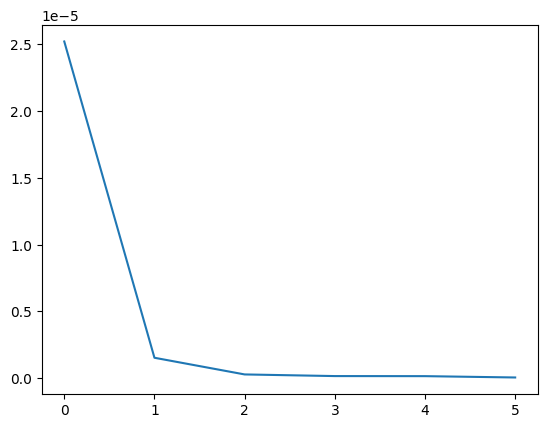

In [140]:
plt.plot(epochs_counts,training_losses)